In [1]:
import numpy as np
from itertools import product
import pandas as pd
import tensorflow as tf
import multiprocessing
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers import Activation, MaxPool2D, Concatenate, RandomContrast
from keras.callbacks import EarlyStopping, ModelCheckpoint


2023-07-15 08:39:28.820437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-15 08:39:28.825067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 08:39:28.917673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 08:39:28.918771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 08:39:30.719213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:

num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=num_cores,
                                  intra_op_parallelism_threads=num_cores)
tf.compat.v1.Session(config=config)


Import necessários para a criação do modelo de rede neural

In [3]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 2

epochs = 1
batch_size = 64

seed = 42
np.random.seed = seed
random.seed = seed

filepath = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/model60-40.h5"

caminho_df_banda11 = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processado/treino_df/df_banda11.csv"
caminho_df_banda12 = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processado/treino_df/df_banda12.csv"
caminho_df_mask = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/treino_processado/treino_df_mascara/df_mask_fires.csv"
caminho_df_banda11_teste = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_processado/arquivos_teste/arquivos_teste_banda11/teste_df_banda11.csv"
caminho_df_banda12_teste = "/home/cristiano/Imagens/imagens_originais/Sentinel-2/teste_processado/arquivos_teste/arquivos_teste_banda12/teste_df_banda12.csv"


Carregamento das Imagens

In [4]:
treino_df_banda11 = pd.read_csv(caminho_df_banda11)
treino_df_banda12 = pd.read_csv(caminho_df_banda12)
treino_df_mask = pd.read_csv(caminho_df_mask)

teste_df_banda11 = pd.read_csv(caminho_df_banda11_teste)
teste_df_banda12 = pd.read_csv(caminho_df_banda12_teste)

In [5]:
# Obter listas de IDs
train_banda1_id_list = treino_df_banda11.index.tolist()
train_banda2_id_list = treino_df_banda12.index.tolist()
train_mask_id_list = treino_df_mask.index.tolist()

NUM_TRAIN_IMAGES = treino_df_mask.shape[0]

# Definir shapes dos arrays
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 2

In [6]:
X_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# mask = resize((IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)     

X_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)


In [7]:
X_train.shape, Y_train.shape

((1912, 64, 64, 2), (1912, 64, 64, 1))

In [8]:
X_test.shape

(1912, 64, 64, 2)

In [9]:
# X_train, Y_train, = train_test_split(X_train, Y_train, test_size = 0.30, random_state = 42)

In [10]:
X_train.shape

(1912, 64, 64, 2)

In [11]:
# X_val.shape

In [12]:
Y_train.shape

(1912, 64, 64, 1)

In [13]:
# Y_val.shape

Criação do Modelo U-Net

In [14]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)  # Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
      
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [15]:

my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
my_unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
my_unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['batch_normalization[0][0]']

Callbacks

In [16]:
earlystopper = EarlyStopping(patience=10,  monitor='val_loss')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]

In [17]:
history = my_unet.fit(X_train, Y_train, validation_split=0.1, batch_size= batch_size, epochs = epochs, callbacks=callbacks_list)


27/27 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 1.0000 
Epoch 1: val_loss improved from inf to 0.67975, saving model to /home/cristiano/Imagens/imagens_originais/Sentinel-2/model60-40.h5
27/27 [==============================] - 331s 12s/step - loss: 0.6867 - accuracy: 1.0000 - val_loss: 0.6797 - val_accuracy: 1.0000


In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
def mostrar_graficos(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy validação')
  plt.legend()
  plt.title('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label='Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
  plt.legend()
  plt.title('Loss')
  plt.show()

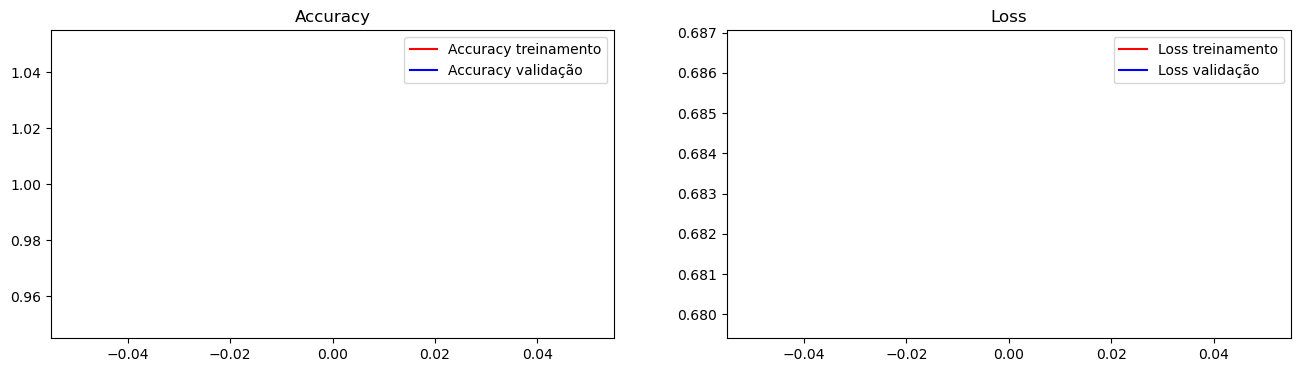

In [20]:
mostrar_graficos(history)

In [21]:
# use the best epoch
# my_unet.load_weights('/home/cristiano/Imagens/imagens_originais/Sentinel-2/model60-40.h5')
my_unet.load_weights(filepath)
test_preds = my_unet.predict(X_test)

# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
preds_test_thresh = preds_test_thresh.reshape((len(X_test), IMG_WIDTH, IMG_HEIGHT, 1))

print("Evaluate on test data")
results = my_unet.evaluate(X_test, Y_train)
print("test loss: ", results)

"""IOU"""

mean_iou1 = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou1.update_state(Y_train, preds_test_thresh, sample_weight=None)
iou = mean_iou1.result().numpy()
print("IOU: ", iou)

"""Accuracy"""

acc1 = tf.keras.metrics.Accuracy()
acc1.update_state(Y_train, preds_test_thresh)
acc = acc1.result().numpy()
print("acurácia: ", acc)

60/60 [==============================] - 138s 2s/step
Evaluate on test data
60/60 [==============================] - 141s 2s/step - loss: 0.6797 - accuracy: 1.0000
test loss:  [0.6797499656677246, 1.0]
IOU:  1.0
acurácia:  1.0


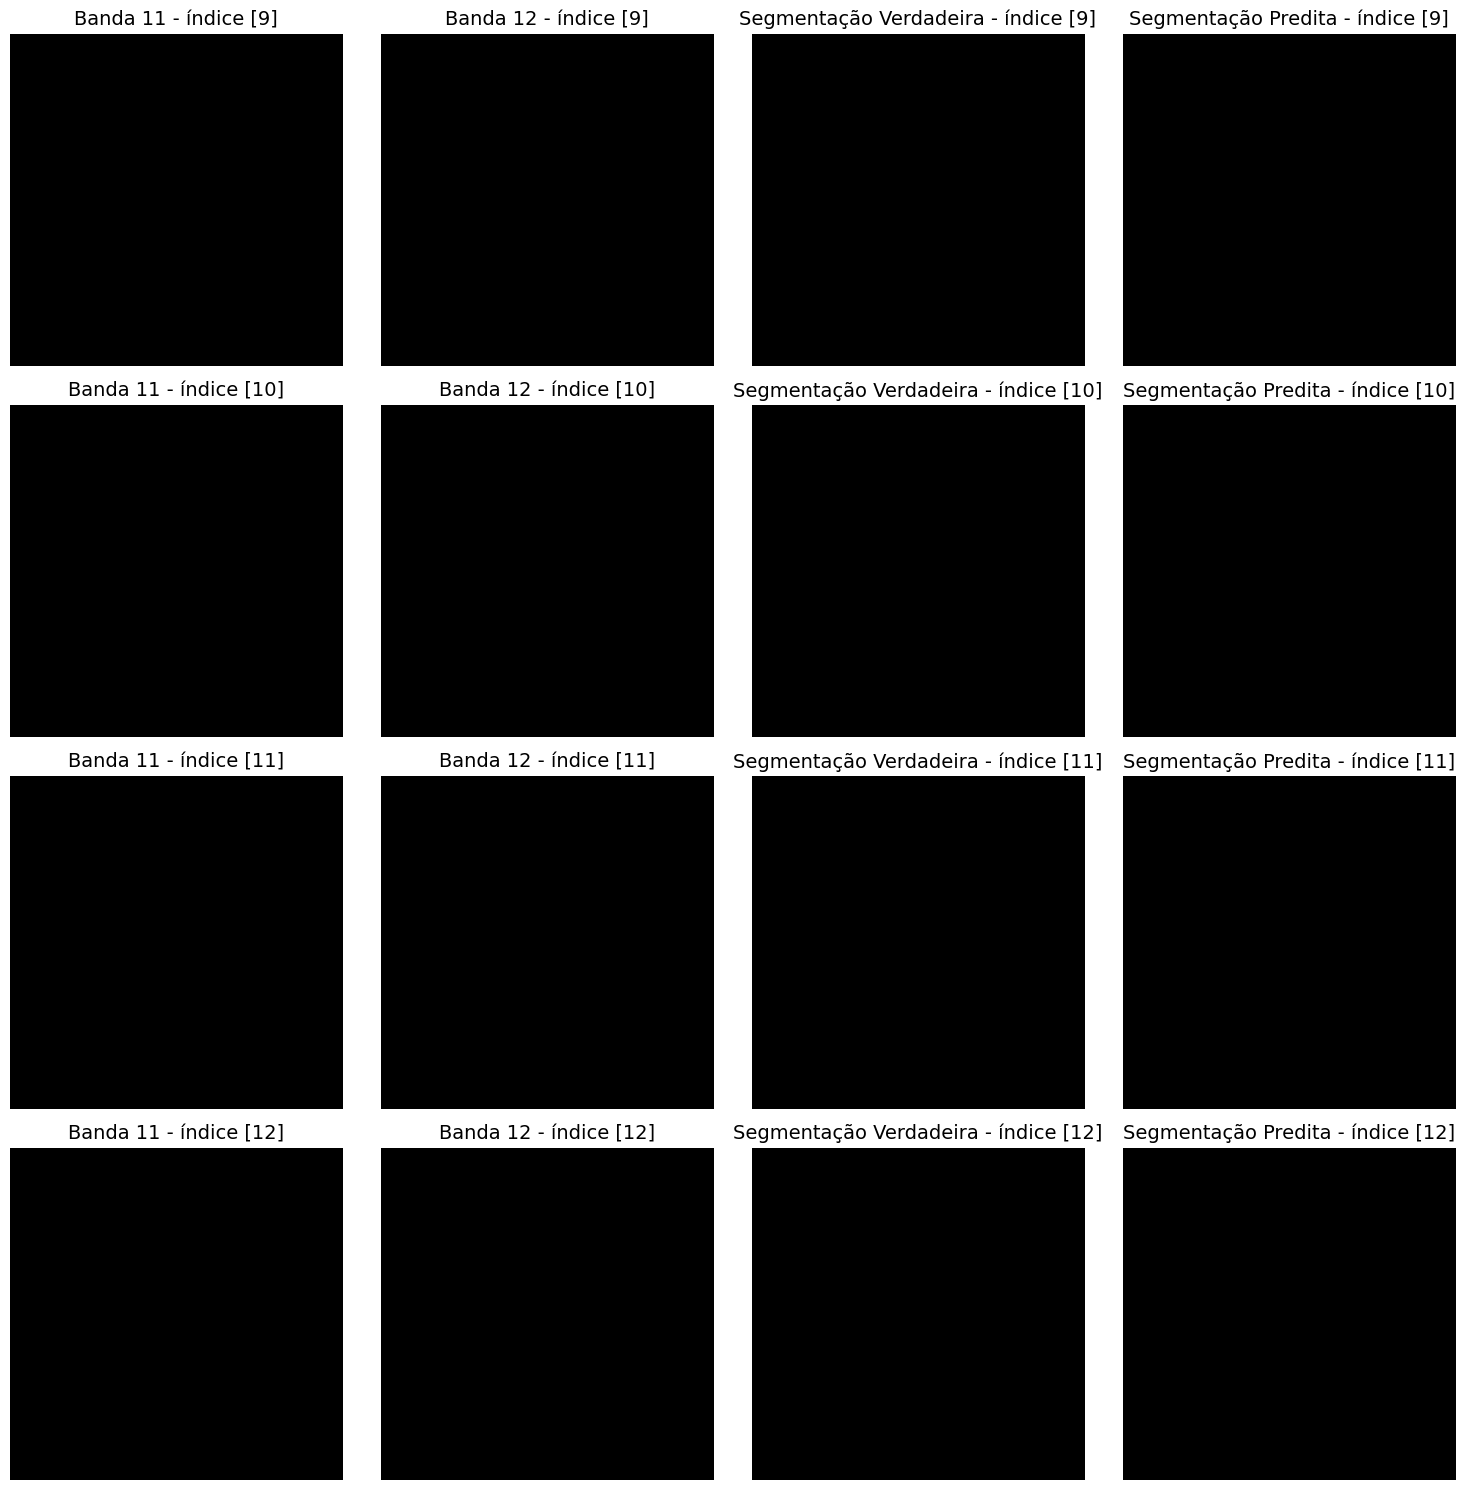

In [22]:
def plot_resultado(quantidade=4, random=3):
    #indices = df_test.sample(quantidade, random_state=random).index.values
    indices = [9,10,11,12]
    plt.figure(figsize=(15, 15))
    j = 1
    for i in range(quantidade):
        # rgb = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b1 = X_test[indices[i], :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indices[i], :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = X_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indices[i]]
        img_pred = preds_test_thresh[indices[i]].reshape((IMG_HEIGHT, IMG_WIDTH))

        # imgs = [rgb, b1, b2, seg, img_pred]
        # names = ['RGB','Banda 11', 'Banda 12', 'Segmentação Verdadeira', 'Segmentação Predita']

        imgs = [b1, b2, seg, img_pred]
        names = ['Banda 11', 'Banda 12', 'Segmentação Verdadeira', 'Segmentação Predita']


        for img, nome in zip(imgs, names):
            plt.subplot(quantidade, 4, j)
            plt.imshow(img, cmap='gray')
            plt.title(str(nome) + ' - índice [' + str(indices[i]) + ']', fontsize=14)
            plt.axis('off')
            j += 1
    plt.tight_layout()
    plt.show()


plot_resultado()

In [23]:
import cv2

# Carregar a imagem binarizada
image = cv2.imread('imagem_binaria.png', 0)  # Certifique-se de fornecer o caminho correto para sua imagem

# Encontrar os pixels com valor 1
non_zero_pixels = cv2.findNonZero(image)

# Exibir as coordenadas dos pixels encontrados
for pixel in non_zero_pixels:
    x, y = pixel[0]
    print(f"Pixel encontrado em x={x}, y={y}")

[ WARN:0@0.015] global loadsave.cpp:244 findDecoder imread_('imagem_binaria.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/core/src/count_non_zero.dispatch.cpp:160: error: (-215:Assertion failed) src.channels() == 1 && src.dims == 2 in function 'findNonZero'


In [ ]:
import cv2
import pandas as pd

# Carregar o DataFrame contendo os dados, supondo que ele seja chamado "df"
df = pd.read_csv('seu_dataframe.csv')  # Certifique-se de fornecer o caminho correto para o seu DataFrame

# Obter o índice da imagem que você deseja buscar
indice_imagem = 0  # Substitua 0 pelo índice correto da imagem desejada

# Obter o caminho da imagem com base no índice no DataFrame
caminho_imagem = df.loc[indice_imagem, 'caminho_imagem']  # Substitua 'caminho_imagem' pelo nome da coluna no DataFrame que contém os caminhos das imagens

# Carregar a imagem binarizada
image = cv2.imread(caminho_imagem, 0)

# Encontrar os pixels com valor 1
non_zero_pixels = cv2.findNonZero(image)

# Calcular a latitude e longitude do pixel central
resolucao_espacial = 10  # Substitua pelo tamanho real de cada pixel em metros
latitude_referencia = 40.0  # Substitua pela latitude de referência correspondente ao canto superior esquerdo da imagem
longitude_referencia = -70.0  # Substitua pela longitude de referência correspondente ao canto superior esquerdo da imagem

for pixel in non_zero_pixels:
    x, y = pixel[0]

    # Calcular a latitude e longitude do pixel central
    latitude = latitude_referencia - (y + 0.5) * resolucao_espacial
    longitude = longitude_referencia + (x + 0.5) * resolucao_espacial

    print(f"Pixel encontrado em x={x}, y={y}")
    print(f"Latitude={latitude}, Longitude={longitude}")
